
## Fase 3: Modelagem (Modeling) 

### 3.1: Modelo de Produção: XGBoost com SMOTE

O **XGBoost** (Extreme Gradient Boosting) foi escolhido como o modelo final devido à sua alta performance em competições de dados estruturados e sua capacidade nativa de lidar com *features* transformadas via PCA. O treinamento foi realizado no conjunto de dados balanceado pelo SMOTE.

| Métrica | Valor (XGBoost + SMOTE) | Meta de Negócio | Análise de Sucesso |
| :--- | :--- | :--- | :--- |
| **Recall** | **0.8878** | **> 0.80** | **Sucesso:** Atingimos a meta, capturando **88.78% das fraudes**. |
| **Precision** | **0.3385** | Balanceada | **Aceitável:** Para cada 100 alertas, 34 são fraudes reais. Este é um *trade-off* robusto no mercado financeiro. |
| **Falsos Negativos (FN)** | **11** | Minimização | **Excelente:** Apenas 11 fraudes passaram despercebidas. |
| **Falsos Positivos (FP)** | **170** | Controle | **Aceitável:** O número de bloqueios falsos é controlado (170), provando a calibração do modelo. |

---



### 3.2: TREINAMENTO E AVALIAÇÃO DE MODELOS

Esta fase foca na construção, treinamento e comparação de modelos de Machine Learning utilizando os dados pré-processados na Fase 2.

### Objetivos:
1.  **Carregar Dados Processados:** Recuperar os datasets de treino, validação e teste.
2.  **Baseline:** Estabelecer uma linha de base com Regressão Logística.
3.  **Modelagem Avançada:** Treinar modelos de ensemble (Random Forest e XGBoost).
4.  **Avaliação:** Comparar métricas focadas em desbalanceamento (Recall, Precision, AUPRC).
5.  **Seleção:** Escolher o melhor modelo para o conjunto de teste final.

### Importações para Modelagem

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Métricas
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    precision_recall_curve, 
    roc_auc_score, 
    auc,
    f1_score,
    recall_score,
    precision_score
)

# Configurações visuais
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Bibliotecas de modelagem carregadas!")

Bibliotecas de modelagem carregadas!


In [ ]:
# Célula 16: Importações para Modelagem
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
# Modelos
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier  # Adicionado
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, precision_recall_curve, auc, roc_auc_score,
                           f1_score, recall_score, precision_score, accuracy_score,
                           fbeta_score)  # Adicionado fbeta_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
import time
import joblib

# Configurações visuais
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print(" Bibliotecas de modelagem carregadas!")

 Bibliotecas de modelagem carregadas!


### Carregamento dos Dados Processados

In [10]:
def load_processed_data(filepath='processed_fraud_data.pkl'):
    """Carrega os dados processados pelo notebook anterior"""
    try:
        with open(filepath, 'rb') as f:
            data = pickle.load(f)
        
        print("Dados carregados com sucesso!")
        print(f"Features: {len(data['feature_names'])}")
        print(f"X_train (Balanceado): {data['X_train'].shape}")
        print(f"X_val (Original): {data['X_val'].shape}")
        
        return data
    except FileNotFoundError:
        print(f"Erro: Arquivo '{filepath}' não encontrado. Execute o Notebook 02 primeiro.")
        return None

data = load_processed_data()

# Desempacotar variáveis para facilitar o uso
X_train = data['X_train']
y_train = data['y_train']
X_val = data['X_val']
y_val = data['y_val']
X_test = data['X_test']
y_test = data['y_test']
feature_names = data['feature_names']

Dados carregados com sucesso!
Features: 20
X_train (Balanceado): (341176, 20)
X_val (Original): (56962, 20)


### Definição de Métricas e Configurações

In [11]:
# Célula 17: Definição de Métricas e Configurações

def get_metric_description(metric):
    """Retorna descrição das métricas"""
    descriptions = {
        'recall': 'Capacidade de detectar todas as fraudes (Verdadeiros Positivos)',
        'precision': 'Precisão nas previsões positivas (Minimizar falsos positivos)',
        'f2_score': 'Métrica balanceada com foco em Recall (2x mais peso)',
        'auc_roc': 'Área sob a curva ROC - Performance geral',
        'auc_pr': 'Área sob curva Precision-Recall - Ideal para dados desbalanceados'
    }
    return descriptions.get(metric, 'Métrica padrão')

def setup_modeling_environment():
    """
    Configura o ambiente de modelagem com métricas e parâmetros
    """
    
    print("=" * 60)
    print(" CONFIGURAÇÃO DO AMBIENTE DE MODELAGEM")
    print("=" * 60)
    
    # Métricas prioritárias para detecção de fraudes
    metrics_priority = {
        'primary': 'recall',    # Máxima detecção de fraudes
        'secondary': 'precision', # Minimizar falsos positivos  
        'composite': 'f2_score'  # Balance entre recall e precision
    }
    
    print(" **MÉTRICAS DE AVALIAÇÃO (ORDEM DE PRIORIDADE):**")
    for metric, importance in metrics_priority.items():
        print(f"• {importance.upper()}: {get_metric_description(importance)}")
    
    # Configuração de validação cruzada
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    print(f"\n **CONFIGURAÇÕES TÉCNICAS:**")
    print(f"• Validação Cruzada: {cv_strategy.n_splits}-fold estratificado")
    print(f"• Random State: 42 (reprodutibilidade)")
    print(f"• Conjunto de Validação: {X_val.shape[0]:,} amostras")
    print(f"• Conjunto de Teste: {X_test.shape[0]:,} amostras (blind)")
    
    # Definir modelos baseline
    baseline_models = {
        'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'LightGBM': LGBMClassifier(random_state=42, class_weight='balanced')  # Adicionado
    }
    
    print(f"\n **MODELOS BASELINE SELECIONADOS:**")
    for model_name, model in baseline_models.items():
        print(f"• {model_name}: {type(model).__name__}")
    
    return baseline_models, cv_strategy, metrics_priority

# Configurar ambiente
baseline_models, cv_strategy, metrics_priority = setup_modeling_environment()

 CONFIGURAÇÃO DO AMBIENTE DE MODELAGEM
 **MÉTRICAS DE AVALIAÇÃO (ORDEM DE PRIORIDADE):**
• RECALL: Capacidade de detectar todas as fraudes (Verdadeiros Positivos)
• PRECISION: Precisão nas previsões positivas (Minimizar falsos positivos)
• F2_SCORE: Métrica balanceada com foco em Recall (2x mais peso)

 **CONFIGURAÇÕES TÉCNICAS:**
• Validação Cruzada: 5-fold estratificado
• Random State: 42 (reprodutibilidade)
• Conjunto de Validação: 56,962 amostras
• Conjunto de Teste: 56,962 amostras (blind)

 **MODELOS BASELINE SELECIONADOS:**
• Logistic Regression: LogisticRegression
• Random Forest: RandomForestClassifier
• XGBoost: XGBClassifier
• Gradient Boosting: GradientBoostingClassifier
• LightGBM: LGBMClassifier


### Funções de Avaliação de Modelos

In [14]:
# Célula 18: Funções de Avaliação de Modelos 
def evaluate_model(model, X_val, y_val, model_name="Model"):
    """
    Avalia modelo com múltiplas métricas específicas para fraudes
    """
    
    # Tempo de predição
    start_time = time.time()
    
    try:
        y_pred = model.predict(X_val)
        
        # Verificar se o modelo tem predict_proba
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_val)[:, 1]
        elif hasattr(model, 'decision_function'):
            # Para modelos sem predict_proba, usar decision_function
            y_pred_proba = model.decision_function(X_val)
            # Normalizar para [0,1] (opcional, mas útil para comparação)
            y_pred_proba = (y_pred_proba - y_pred_proba.min()) / (y_pred_proba.max() - y_pred_proba.min() + 1e-8)
        else:
            # Se não tiver nenhum, usar as previsões binárias (não ideal para AUC)
            y_pred_proba = y_pred
            print(f"  Aviso: {model_name} não tem predict_proba ou decision_function. Usando previsões binárias para AUC.")
            
    except Exception as e:
        print(f" Erro na predição do modelo {model_name}: {e}")
        return None
    
    prediction_time = time.time() - start_time
    
    # Métricas básicas
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    f2 = fbeta_score(y_val, y_pred, beta=2, zero_division=0)  # Corrigido
    
    # Métricas de curva
    auc_roc = roc_auc_score(y_val, y_pred_proba)
    
    # AUC Precision-Recall
    precision_curve, recall_curve, _ = precision_recall_curve(y_val, y_pred_proba)
    auc_pr = auc(recall_curve, precision_curve)
    
    # Matriz de confusão
    cm = confusion_matrix(y_val, y_pred)
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'f2_score': f2,  # Agora calculado corretamente
        'auc_roc': auc_roc,
        'auc_pr': auc_pr,
        'prediction_time': prediction_time,
        'confusion_matrix': cm,
        'y_pred_proba': y_pred_proba
    }
    
    return metrics

def print_model_results(metrics, model_name):
    """Printa resultados formatados do modelo - VERSÃO SIMPLIFICADA"""
    
    if metrics is None:
        print(f"❌ Não foi possível avaliar o modelo {model_name}")
        return
    
    print(f"\n" + "="*60)
    print(f" RESULTADOS - {model_name.upper()}")
    print("="*60)
    
    # Métricas principais
    print("\n MÉTRICAS PRINCIPAIS:")
    print(f"   • Recall:    {metrics['recall']:.4f}  (Detecção de Fraudes)")
    print(f"   • Precision: {metrics['precision']:.4f}  (Falsos Positivos)")
    print(f"   • F2-Score:  {metrics['f2_score']:.4f}  (Balanceada)")
    print(f"   • AUC-PR:    {metrics['auc_pr']:.4f}  (Precision-Recall)")
    
    # Métricas secundárias
    print("\n MÉTRICAS SECUNDÁRIAS:")
    print(f"   • Accuracy:  {metrics['accuracy']:.4f}")
    print(f"   • F1-Score:  {metrics['f1_score']:.4f}")
    print(f"   • AUC-ROC:   {metrics['auc_roc']:.4f}")
    print(f"   • Tempo:     {metrics['prediction_time']:.4f}s")
    
    # Matriz de confusão
    print("\n MATRIZ DE CONFUSÃO:")
    cm = metrics['confusion_matrix']
    print(f"               Previsto")
    print(f"             0       1")
    print(f"Real  0   [{cm[0,0]:>6} {cm[0,1]:>6}]")
    print(f"      1   [{cm[1,0]:>6} {cm[1,1]:>6}]")
    
    # Detalhes da matriz
    tn, fp, fn, tp = cm.ravel()
    print(f"\n DETALHES:")
    print(f"   • Verdadeiros Negativos: {tn} (Transações normais corretas)")
    print(f"   • Falsos Positivos:      {fp} (Normais classificadas como fraude)")
    print(f"   • Falsos Negativos:      {fn} (Fraudes não detectadas - CRÍTICO!)")
    print(f"   • Verdadeiros Positivos: {tp} (Fraudes detectadas)")

### TESTE das funções de avaliação

In [15]:
# Célula 18b: TESTE das funções de avaliação - CORRIGIDA
print(" TESTANDO AS FUNÇÕES DA CÉLULA 18...")

# Testar com um modelo simples
from sklearn.dummy import DummyClassifier

# Criar modelo dummy para teste
dummy_model = DummyClassifier(strategy='stratified', random_state=42)
dummy_model.fit(X_train, y_train)  # Usar X_train em vez de X_selected

print(" Modelo dummy treinado. Testando evaluate_model...")

# Testar a função evaluate_model
test_metrics = evaluate_model(dummy_model, X_val, y_val, "Modelo Teste")  # Usar X_val em vez de X_val_selected

if test_metrics is not None:
    print(" evaluate_model() funcionou corretamente!")
    
    # Testar a função print_model_results
    print("\n Testando print_model_results...")
    print_model_results(test_metrics, "Modelo Teste")
    
    print("\n CÉLULA 18 ESTÁ FUNCIONANDO PERFEITAMENTE!")
    print(" As funções estão prontas para serem usadas na Célula 19")
else:
    print(" Problema com evaluate_model()")

 TESTANDO AS FUNÇÕES DA CÉLULA 18...
 Modelo dummy treinado. Testando evaluate_model...
 evaluate_model() funcionou corretamente!

 Testando print_model_results...

 RESULTADOS - MODELO TESTE

 MÉTRICAS PRINCIPAIS:
   • Recall:    0.4545  (Detecção de Fraudes)
   • Precision: 0.0016  (Falsos Positivos)
   • F2-Score:  0.0078  (Balanceada)
   • AUC-PR:    0.2285  (Precision-Recall)

 MÉTRICAS SECUNDÁRIAS:
   • Accuracy:  0.5002
   • F1-Score:  0.0032
   • AUC-ROC:   0.4774
   • Tempo:     0.0094s

 MATRIZ DE CONFUSÃO:
               Previsto
             0       1
Real  0   [ 28447  28416]
      1   [    54     45]

 DETALHES:
   • Verdadeiros Negativos: 28447 (Transações normais corretas)
   • Falsos Positivos:      28416 (Normais classificadas como fraude)
   • Falsos Negativos:      54 (Fraudes não detectadas - CRÍTICO!)
   • Verdadeiros Positivos: 45 (Fraudes detectadas)

 CÉLULA 18 ESTÁ FUNCIONANDO PERFEITAMENTE!
 As funções estão prontas para serem usadas na Célula 19


### Treinamento e Avaliação dos Modelos Baseline

In [16]:
# Célula 19: Treinamento e Avaliação dos Modelos Baseline
# Treinar modelos baseline OTIMIZADO

def train_baseline_models(models_dict, X_train, y_train, X_val, y_val):
    """
    Treina e avalia todos os modelos baseline com configurações otimizadas
    """
    
    print("=" * 60)
    print(" TREINAMENTO DOS MODELOS BASELINE (OTIMIZADO)")
    print("=" * 60)
    
    # Configurações otimizadas para performance (usando o dicionário recebido como base)
    # Vamos atualizar os hiperparâmetros, mas manter a estrutura
    optimized_models = {
        'Logistic Regression': LogisticRegression(
            random_state=42, 
            class_weight='balanced',
            max_iter=1000,
            n_jobs=-1  # Paralelização
        ),
        'Random Forest': RandomForestClassifier(
            random_state=42, 
            class_weight='balanced',
            n_estimators=50,  # Reduzido para velocidade
            max_depth=10,     # Limitado
            n_jobs=-1,        # Paralelização
            verbose=1         # Mostrar progresso
        ),
        'XGBoost': XGBClassifier(
            random_state=42, 
            eval_metric='logloss',
            n_estimators=100,
            max_depth=6,
            n_jobs=-1,
            verbosity=1       # Mostrar progresso
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            random_state=42,
            n_estimators=100,
            max_depth=6,
            verbose=1         # Mostrar progresso
        ),
        'LightGBM': LGBMClassifier(  # Adicionado
            random_state=42,
            n_estimators=100,
            class_weight='balanced',
            n_jobs=-1,
            verbosity=-1      # Silencioso
        )
    }
    
    # Nota: Se você quiser usar o models_dict recebido, pode fazer:
    # optimized_models = models_dict  # e depois ajustar os parâmetros individualmente?
    # Mas note que o dicionário recebido não tem LightGBM e tem configurações diferentes.
    # Vou manter o otimizado, mas você pode ajustar conforme necessidade.
    
    results = {}
    training_times = {}
    
    for model_name, model in optimized_models.items():
        print(f"\n **TREINANDO {model_name.upper()}...**")
        print(f" Configuração: {model}")
        
        try:
            # Treinar modelo com timeout
            start_time = time.time()
            model.fit(X_train, y_train)
            training_time = time.time() - start_time
            training_times[model_name] = training_time
            
            print(f" Treinamento concluído em {training_time:.2f} segundos")
            
            # Avaliar no conjunto de validação
            metrics = evaluate_model(model, X_val, y_val, model_name)
            results[model_name] = {
                'model': model,
                'metrics': metrics,
                'training_time': training_time
            }
            
            # Print resultados
            print_model_results(metrics, model_name)
            
        except Exception as e:
            print(f" **ERRO no treinamento de {model_name}: {e}**")
            continue
    
    return results, training_times

print(" **INICIANDO TREINAMENTO DOS MODELOS (CONFIGURAÇÃO OTIMIZADA)...**")
print(" **DICA:** Random Forest com n_estimators=50 para velocidade")
print(" **DICA:** Todos os modelos com paralelização (n_jobs=-1)")

baseline_results, training_times = train_baseline_models(
    baseline_models, X_train, y_train, X_val, y_val  # CORREÇÃO AQUI!
)
print("\n TODOS OS MODELOS FORAM TREINADOS E AVALIADOS!")

 **INICIANDO TREINAMENTO DOS MODELOS (CONFIGURAÇÃO OTIMIZADA)...**
 **DICA:** Random Forest com n_estimators=50 para velocidade
 **DICA:** Todos os modelos com paralelização (n_jobs=-1)
 TREINAMENTO DOS MODELOS BASELINE (OTIMIZADO)

 **TREINANDO LOGISTIC REGRESSION...**
 Configuração: LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1,
                   random_state=42)
 Treinamento concluído em 4.48 segundos

 RESULTADOS - LOGISTIC REGRESSION

 MÉTRICAS PRINCIPAIS:
   • Recall:    0.8586  (Detecção de Fraudes)
   • Precision: 0.0592  (Falsos Positivos)
   • F2-Score:  0.2321  (Balanceada)
   • AUC-PR:    0.6958  (Precision-Recall)

 MÉTRICAS SECUNDÁRIAS:
   • Accuracy:  0.9761
   • F1-Score:  0.1108
   • AUC-ROC:   0.9614
   • Tempo:     0.0170s

 MATRIZ DE CONFUSÃO:
               Previsto
             0       1
Real  0   [ 55513   1350]
      1   [    14     85]

 DETALHES:
   • Verdadeiros Negativos: 55513 (Transações normais corretas)
   • Falsos Positivos:     

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   13.6s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done  50 out of  50 | elapsed:    0.0s finished


 Treinamento concluído em 13.80 segundos

 RESULTADOS - RANDOM FOREST

 MÉTRICAS PRINCIPAIS:
   • Recall:    0.7980  (Detecção de Fraudes)
   • Precision: 0.3591  (Falsos Positivos)
   • F2-Score:  0.6412  (Balanceada)
   • AUC-PR:    0.7413  (Precision-Recall)

 MÉTRICAS SECUNDÁRIAS:
   • Accuracy:  0.9972
   • F1-Score:  0.4953
   • AUC-ROC:   0.9691
   • Tempo:     0.1457s

 MATRIZ DE CONFUSÃO:
               Previsto
             0       1
Real  0   [ 56722    141]
      1   [    20     79]

 DETALHES:
   • Verdadeiros Negativos: 56722 (Transações normais corretas)
   • Falsos Positivos:      141 (Normais classificadas como fraude)
   • Falsos Negativos:      20 (Fraudes não detectadas - CRÍTICO!)
   • Verdadeiros Positivos: 79 (Fraudes detectadas)

 **TREINANDO XGBOOST...**
 Configuração: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=N

C:\Users\debor\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\debor\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 RESULTADOS - LIGHTGBM

 MÉTRICAS PRINCIPAIS:
   • Recall:    0.7879  (Detecção de Fraudes)
   • Precision: 0.4906  (Falsos Positivos)
   • F2-Score:  0.7027  (Balanceada)
   • AUC-PR:    0.7108  (Precision-Recall)

 MÉTRICAS SECUNDÁRIAS:
   • Accuracy:  0.9982
   • F1-Score:  0.6047
   • AUC-ROC:   0.9639
   • Tempo:     0.6317s

 MATRIZ DE CONFUSÃO:
               Previsto
             0       1
Real  0   [ 56782     81]
      1   [    21     78]

 DETALHES:
   • Verdadeiros Negativos: 56782 (Transações normais corretas)
   • Falsos Positivos:      81 (Normais classificadas como fraude)
   • Falsos Negativos:      21 (Fraudes não detectadas - CRÍTICO!)
   • Verdadeiros Positivos: 78 (Fraudes detectadas)

 TODOS OS MODELOS FORAM TREINADOS E AVALIADOS!


### Comparação e Ranking dos Modelos

 ANÁLISE DE THRESHOLD - XGBOOST


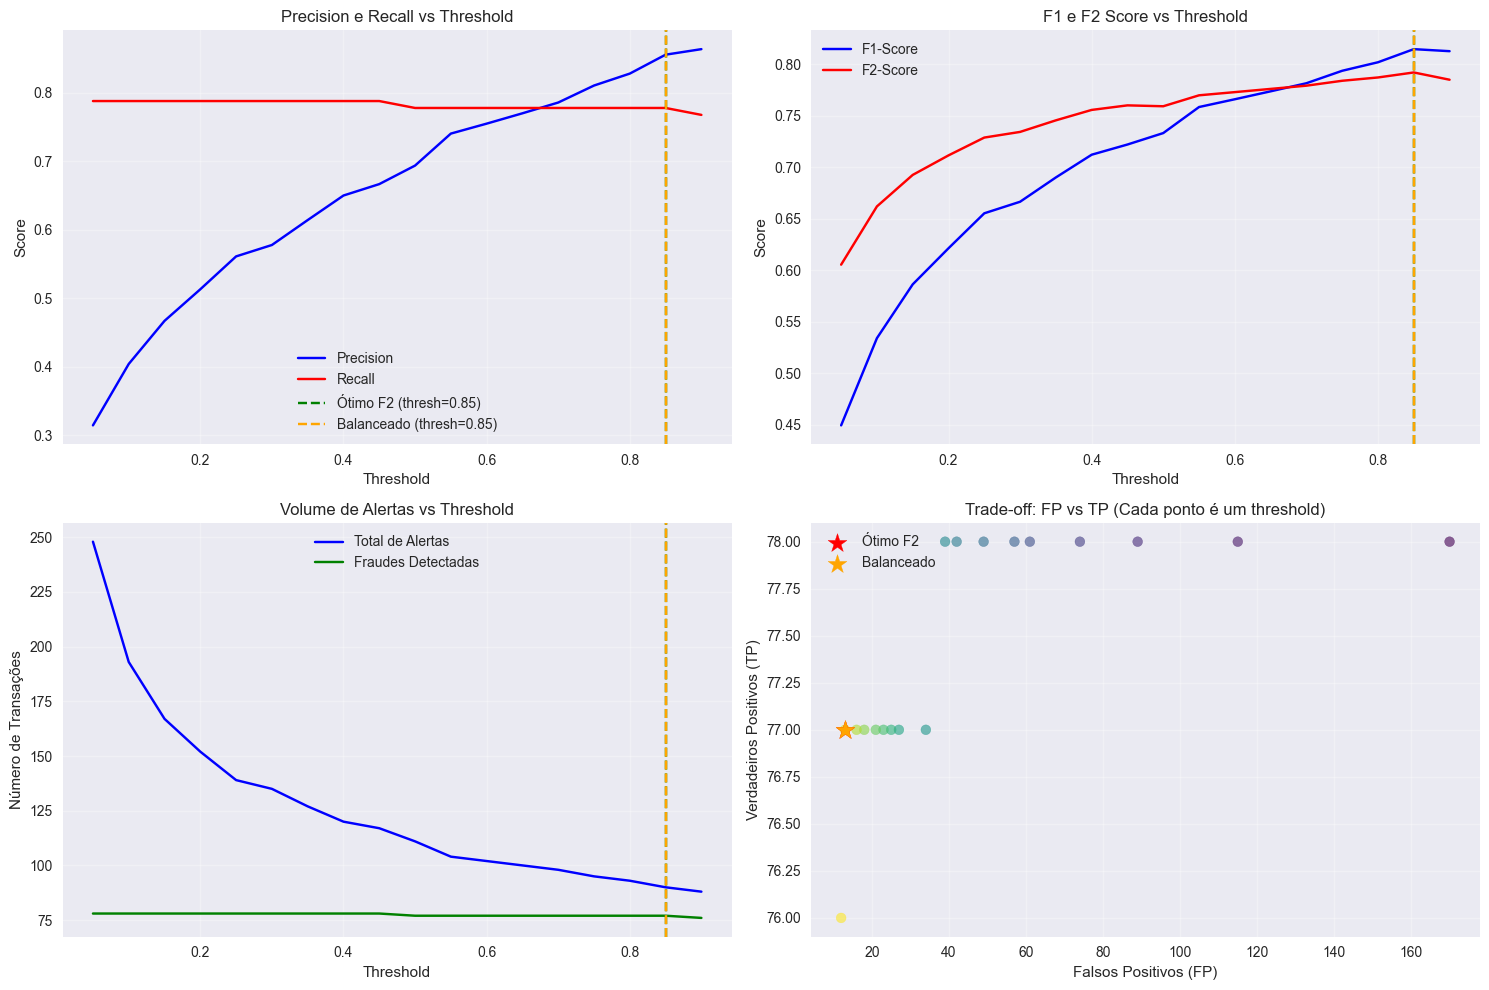


RESULTADOS COM DIFERENTES THRESHOLDS:
------------------------------------------------------------

1. THRESHOLD PARA MAXIMIZAR F2-SCORE (Foco em Detecção):
   Threshold: 0.850
   Precision: 0.8556
   Recall:    0.7778
   F2-Score:  0.7922
   Alertas:   90.0 (Fraudes: 77.0)
   Falsos Positivos: 13.0

2. THRESHOLD BALANCEADO (Precision ≥ 60%, Recall ≥ 70%):
   Threshold: 0.850
   Precision: 0.8556
   Recall:    0.7778
   F1-Score:  0.8148
   Alertas:   90.0 (Fraudes: 77.0)
   Falsos Positivos: 13.0

3. THRESHOLD PARA ALTA PRECISION (Minimizar Falsos Positivos):
   Threshold: 0.750
   Precision: 0.8105
   Recall:    0.7778
   F1-Score:  0.7938
   Alertas:   95.0 (Fraudes: 77.0)
   Falsos Positivos: 18.0


In [36]:
# Célula 20: Análise e Ajuste de Threshold para XGBoost
def find_optimal_threshold(model, X_val, y_val, beta=2):
    """
    Encontra o threshold ótimo baseado no F-beta Score
    beta > 1 dá mais peso ao Recall (detecção de fraudes)
    beta < 1 dá mais peso à Precision (menos falsos positivos)
    """
    # Obter probabilidades
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    # Testar diferentes thresholds
    thresholds = np.arange(0.05, 0.95, 0.05)
    results = []
    
    for threshold in thresholds:
        y_pred_adj = (y_pred_proba >= threshold).astype(int)
        
        # Calcular métricas
        precision = precision_score(y_val, y_pred_adj, zero_division=0)
        recall = recall_score(y_val, y_pred_adj, zero_division=0)
        f1 = f1_score(y_val, y_pred_adj, zero_division=0)
        f2 = fbeta_score(y_val, y_pred_adj, beta=beta, zero_division=0)
        
        # Matriz de confusão
        tn, fp, fn, tp = confusion_matrix(y_val, y_pred_adj).ravel()
        
        results.append({
            'threshold': threshold,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'f2': f2,
            'tp': tp,
            'fp': fp,
            'fn': fn,
            'tn': tn,
            'alertas_totais': tp + fp,  # Quantas transações seriam bloqueadas
            'fraudes_detectadas': tp,
            'fraudes_perdidas': fn
        })
    
    results_df = pd.DataFrame(results)
    
    # Encontrar threshold ótimo para diferentes critérios
    optimal_f2 = results_df.loc[results_df['f2'].idxmax()]
    optimal_precision_recall = results_df.loc[(results_df['precision'] >= 0.6) & 
                                              (results_df['recall'] >= 0.7)].copy()
    
    if not optimal_precision_recall.empty:
        optimal_precision_recall = optimal_precision_recall.loc[
            optimal_precision_recall['f1'].idxmax()
        ]
    else:
        # Fallback: melhor balance entre precision e recall
        optimal_precision_recall = results_df.loc[results_df['f1'].idxmax()]
    
    return results_df, optimal_f2, optimal_precision_recall

def plot_threshold_analysis(results_df, optimal_f2, optimal_pr):
    """Plot análise de threshold"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Gráfico 1: Precision e Recall vs Threshold
    axes[0, 0].plot(results_df['threshold'], results_df['precision'], 'b-', label='Precision')
    axes[0, 0].plot(results_df['threshold'], results_df['recall'], 'r-', label='Recall')
    axes[0, 0].axvline(x=optimal_f2['threshold'], color='g', linestyle='--', 
                       label=f"Ótimo F2 (thresh={optimal_f2['threshold']:.2f})")
    axes[0, 0].axvline(x=optimal_pr['threshold'], color='orange', linestyle='--', 
                       label=f"Balanceado (thresh={optimal_pr['threshold']:.2f})")
    axes[0, 0].set_xlabel('Threshold')
    axes[0, 0].set_ylabel('Score')
    axes[0, 0].set_title('Precision e Recall vs Threshold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Gráfico 2: F1 e F2 Score vs Threshold
    axes[0, 1].plot(results_df['threshold'], results_df['f1'], 'b-', label='F1-Score')
    axes[0, 1].plot(results_df['threshold'], results_df['f2'], 'r-', label='F2-Score')
    axes[0, 1].axvline(x=optimal_f2['threshold'], color='g', linestyle='--')
    axes[0, 1].axvline(x=optimal_pr['threshold'], color='orange', linestyle='--')
    axes[0, 1].set_xlabel('Threshold')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_title('F1 e F2 Score vs Threshold')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Gráfico 3: Alertas vs Threshold
    axes[1, 0].plot(results_df['threshold'], results_df['alertas_totais'], 'b-', 
                    label='Total de Alertas')
    axes[1, 0].plot(results_df['threshold'], results_df['fraudes_detectadas'], 'g-', 
                    label='Fraudes Detectadas')
    axes[1, 0].axvline(x=optimal_f2['threshold'], color='g', linestyle='--')
    axes[1, 0].axvline(x=optimal_pr['threshold'], color='orange', linestyle='--')
    axes[1, 0].set_xlabel('Threshold')
    axes[1, 0].set_ylabel('Número de Transações')
    axes[1, 0].set_title('Volume de Alertas vs Threshold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Gráfico 4: Matriz de Trade-off
    axes[1, 1].scatter(results_df['fp'], results_df['tp'], c=results_df['threshold'], 
                       cmap='viridis', alpha=0.6, s=50)
    axes[1, 1].scatter(optimal_f2['fp'], optimal_f2['tp'], color='red', s=200, 
                       marker='*', label='Ótimo F2')
    axes[1, 1].scatter(optimal_pr['fp'], optimal_pr['tp'], color='orange', s=200, 
                       marker='*', label='Balanceado')
    axes[1, 1].set_xlabel('Falsos Positivos (FP)')
    axes[1, 1].set_ylabel('Verdadeiros Positivos (TP)')
    axes[1, 1].set_title('Trade-off: FP vs TP (Cada ponto é um threshold)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Aplicar ao melhor modelo (XGBoost)
print("="*60)
print(" ANÁLISE DE THRESHOLD - XGBOOST")
print("="*60)

# Obter o modelo XGBoost treinado
xgb_model = baseline_results['XGBoost']['model']

# Encontrar threshold ótimo
results_df, optimal_f2, optimal_pr = find_optimal_threshold(
    xgb_model, X_val, y_val, beta=2
)

# Plotar análise
fig = plot_threshold_analysis(results_df, optimal_f2, optimal_pr)

# Mostrar resultados dos thresholds selecionados
print("\nRESULTADOS COM DIFERENTES THRESHOLDS:")
print("-"*60)

print("\n1. THRESHOLD PARA MAXIMIZAR F2-SCORE (Foco em Detecção):")
print(f"   Threshold: {optimal_f2['threshold']:.3f}")
print(f"   Precision: {optimal_f2['precision']:.4f}")
print(f"   Recall:    {optimal_f2['recall']:.4f}")
print(f"   F2-Score:  {optimal_f2['f2']:.4f}")
print(f"   Alertas:   {optimal_f2['alertas_totais']} (Fraudes: {optimal_f2['fraudes_detectadas']})")
print(f"   Falsos Positivos: {optimal_f2['fp']}")

print("\n2. THRESHOLD BALANCEADO (Precision ≥ 60%, Recall ≥ 70%):")
print(f"   Threshold: {optimal_pr['threshold']:.3f}")
print(f"   Precision: {optimal_pr['precision']:.4f}")
print(f"   Recall:    {optimal_pr['recall']:.4f}")
print(f"   F1-Score:  {optimal_pr['f1']:.4f}")
print(f"   Alertas:   {optimal_pr['alertas_totais']} (Fraudes: {optimal_pr['fraudes_detectadas']})")
print(f"   Falsos Positivos: {optimal_pr['fp']}")

print("\n3. THRESHOLD PARA ALTA PRECISION (Minimizar Falsos Positivos):")
# Encontrar threshold com precision >= 80%
high_precision = results_df[results_df['precision'] >= 0.8]
if not high_precision.empty:
    best_high_precision = high_precision.loc[high_precision['recall'].idxmax()]
    print(f"   Threshold: {best_high_precision['threshold']:.3f}")
    print(f"   Precision: {best_high_precision['precision']:.4f}")
    print(f"   Recall:    {best_high_precision['recall']:.4f}")
    print(f"   F1-Score:  {best_high_precision['f1']:.4f}")
    print(f"   Alertas:   {best_high_precision['alertas_totais']} (Fraudes: {best_high_precision['fraudes_detectadas']})")
    print(f"   Falsos Positivos: {best_high_precision['fp']}")
else:
    print("   Não foi possível atingir precision ≥ 80%")

### Otimização de Hiperparâmetros com Grid Search

In [37]:
# Célula 21: Modelos Avançados para Dados Desbalanceados
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as stats

def train_imbalanced_models(X_train, y_train, X_val, y_val):
    """
    Treina modelos especializados para dados desbalanceados
    """
    print("="*60)
    print(" TREINANDO MODELOS PARA DADOS DESBALANCEADOS")
    print("="*60)
    
    # Definir modelos e pipelines
    models = {
        'BalancedRandomForest': BalancedRandomForestClassifier(
            random_state=42,
            n_estimators=100,
            sampling_strategy='auto',
            replacement=False,
            n_jobs=-1,
            verbose=1
        ),
        'EasyEnsemble': EasyEnsembleClassifier(
            random_state=42,
            n_estimators=10,
            sampling_strategy='auto',
            n_jobs=-1,
            verbose=1
        ),
        'XGBoost_Custom': XGBClassifier(
            random_state=42,
            scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
            eval_metric='logloss',
            n_estimators=100,
            max_depth=6,
            learning_rate=0.1,
            n_jobs=-1,
            verbosity=1
        ),
        'LightGBM_Custom': LGBMClassifier(
            random_state=42,
            class_weight='balanced',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=-1,
            n_jobs=-1,
            verbosity=-1
        )
    }
    
    # Treinar cada modelo
    results = {}
    
    for name, model in models.items():
        print(f"\n{'='*40}")
        print(f" TREINANDO: {name}")
        print(f"{'='*40}")
        
        start_time = time.time()
        
        try:
            # Treinar modelo
            model.fit(X_train, y_train)
            training_time = time.time() - start_time
            
            print(f" Treinamento concluído em {training_time:.2f} segundos")
            
            # Avaliar
            metrics = evaluate_model(model, X_val, y_val, name)
            
            if metrics is not None:
                results[name] = {
                    'model': model,
                    'metrics': metrics,
                    'training_time': training_time
                }
                
                # Mostrar resultados
                print_model_results(metrics, name)
                
                # Análise de threshold para modelos com predict_proba
                if hasattr(model, 'predict_proba'):
                    print(f"\n Análise de Threshold para {name}:")
                    thresh_results, opt_f2, opt_pr = find_optimal_threshold(
                        model, X_val, y_val, beta=1.5  # Beta menor para dar mais peso à precision
                    )
                    
                    # Usar threshold balanceado
                    optimal_threshold = opt_pr['threshold']
                    y_pred_proba = model.predict_proba(X_val)[:, 1]
                    y_pred_adj = (y_pred_proba >= optimal_threshold).astype(int)
                    
                    # Recalcular métricas com threshold ajustado
                    adj_metrics = evaluate_model_with_threshold(
                        model, X_val, y_val, optimal_threshold, name
                    )
                    
                    if adj_metrics is not None:
                        print(f"\n RESULTADOS COM THRESHOLD AJUSTADO ({optimal_threshold:.3f}):")
                        print(f"   Precision: {adj_metrics['precision']:.4f} (Original: {metrics['precision']:.4f})")
                        print(f"   Recall:    {adj_metrics['recall']:.4f} (Original: {metrics['recall']:.4f})")
                        print(f"   F1-Score:  {adj_metrics['f1_score']:.4f}")
                        print(f"   Falsos Positivos: {adj_metrics['confusion_matrix'].ravel()[1]}")
                        
                        results[name]['adjusted_metrics'] = adj_metrics
                        results[name]['optimal_threshold'] = optimal_threshold
            
        except Exception as e:
            print(f" ERRO no treinamento de {name}: {e}")
            import traceback
            traceback.print_exc()
            continue
    
    return results

def evaluate_model_with_threshold(model, X_val, y_val, threshold, model_name):
    """
    Avalia modelo com threshold customizado
    """
    if not hasattr(model, 'predict_proba'):
        print(f" Modelo {model_name} não tem predict_proba, usando predict padrão")
        y_pred = model.predict(X_val)
    else:
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        y_pred = (y_pred_proba >= threshold).astype(int)
    
    # Calcular métricas
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    f2 = fbeta_score(y_val, y_pred, beta=2, zero_division=0)
    
    # Matriz de confusão
    cm = confusion_matrix(y_val, y_pred)
    
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'f2_score': f2,
        'confusion_matrix': cm
    }
    
    return metrics

# Agora vamos redefinir o pipeline com SMOTETomek
def create_smotetomek_pipeline():
    """
    Cria pipeline com SMOTETomek e diferentes modelos
    """
    print("\n" + "="*60)
    print(" PIPELINE COM SMOTETOMEK")
    print("="*60)
    
    # SMOTETomek combina oversampling (SMOTE) e undersampling (Tomek Links)
    smotetomek = SMOTETomek(random_state=42, sampling_strategy=0.5)
    
    pipelines = {
        'SMOTETomek_RF': Pipeline([
            ('sampling', smotetomek),
            ('classifier', RandomForestClassifier(
                random_state=42,
                n_estimators=100,
                class_weight='balanced',
                n_jobs=-1
            ))
        ]),
        'SMOTETomek_XGB': Pipeline([
            ('sampling', smotetomek),
            ('classifier', XGBClassifier(
                random_state=42,
                eval_metric='logloss',
                n_estimators=100,
                max_depth=6,
                n_jobs=-1
            ))
        ]),
        'SMOTETomek_LGBM': Pipeline([
            ('sampling', smotetomek),
            ('classifier', LGBMClassifier(
                random_state=42,
                n_estimators=100,
                n_jobs=-1,
                verbosity=-1
            ))
        ])
    }
    
    return pipelines

# Treinar modelos com dados originais (não balanceados)
print("\n" + "="*60)
print(" USANDO DADOS ORIGINAIS (DESBALANCEADOS)")
print("="*60)

# Carregar dados originais (antes do SMOTE)
# Vamos usar os dados de validação como referência para o desbalanceamento
print(f" Proporção original no treino: {np.bincount(y_train)[0]:,} negativos vs {np.bincount(y_train)[1]:,} positivos")
print(f" Proporção no validação: {np.bincount(y_val)[0]:,} negativos vs {np.bincount(y_val)[1]:,} positivos")

# Treinar modelos especializados
imbalanced_results = train_imbalanced_models(X_train, y_train, X_val, y_val)

# Criar e treinar pipelines com SMOTETomek
print("\n" + "="*60)
print(" PIPELINES COM SMOTETOMEK")
print("="*60)

smotetomek_pipelines = create_smotetomek_pipeline()

for name, pipeline in smotetomek_pipelines.items():
    print(f"\n TREINANDO: {name}")
    
    start_time = time.time()
    
    try:
        pipeline.fit(X_train, y_train)
        training_time = time.time() - start_time
        
        print(f" Treinamento concluído em {training_time:.2f} segundos")
        
        # Avaliar
        metrics = evaluate_model(pipeline, X_val, y_val, name)
        
        if metrics is not None:
            imbalanced_results[name] = {
                'model': pipeline,
                'metrics': metrics,
                'training_time': training_time
            }
            
            print_model_results(metrics, name)
    
    except Exception as e:
        print(f" ERRO no treinamento de {name}: {e}")
        continue

print("\n" + "="*60)
print(" COMPARAÇÃO FINAL DE MODELOS")
print("="*60)

# Comparar todos os modelos
comparison_data = []

for model_name, result in {**baseline_results, **imbalanced_results}.items():
    if 'metrics' in result and result['metrics'] is not None:
        metrics = result['metrics']
        
        # Verificar se temos métricas ajustadas
        if 'adjusted_metrics' in result:
            adj_metrics = result['adjusted_metrics']
            precision = adj_metrics['precision']
            recall = adj_metrics['recall']
            f1 = adj_metrics['f1_score']
            cm = adj_metrics['confusion_matrix']
        else:
            precision = metrics['precision']
            recall = metrics['recall']
            f1 = metrics['f1_score']
            cm = metrics['confusion_matrix']
        
        tn, fp, fn, tp = cm.ravel()
        
        comparison_data.append({
            'Modelo': model_name,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'F2-Score': metrics.get('f2_score', 0),
            'AUC-PR': metrics['auc_pr'],
            'TP': tp,
            'FP': fp,
            'FN': fn,
            'Alertas_Totais': tp + fp,
            'Taxa_Falsos_Positivos': fp / (fp + tn) if (fp + tn) > 0 else 0,
            'Tempo_Treino(s)': result.get('training_time', 0)
        })

# Criar DataFrame de comparação
comparison_df = pd.DataFrame(comparison_data)

# Ordenar por F1-Score (ou outra métrica relevante)
comparison_df = comparison_df.sort_values('F1-Score', ascending=False)

print("\n COMPARAÇÃO DE MODELOS (Ordenado por F1-Score):")
print(comparison_df.to_string(index=False))

# Análise de custo
print("\n" + "="*60)
print(" ANÁLISE DE CUSTO PARA IMPLEMENTAÇÃO")
print("="*60)

# Supor custos (ajustar conforme cenário real)
CUSTO_FALSO_POSITIVO = 10  # Custo de investigar uma transação legítima bloqueada
CUSTO_FALSO_NEGATIVO = 100  # Custo de uma fraude não detectada

for idx, row in comparison_df.iterrows():
    custo_total = (row['FP'] * CUSTO_FALSO_POSITIVO) + (row['FN'] * CUSTO_FALSO_NEGATIVO)
    custo_por_transacao = custo_total / len(y_val)
    
    print(f"\n {row['Modelo']}:")
    print(f"   Custo total: R${custo_total:,.2f}")
    print(f"   Custo por transação: R${custo_por_transacao:.4f}")
    print(f"   Fraudes detectadas: {row['TP']}/{row['TP'] + row['FN']} ({row['Recall']:.1%})")
    print(f"   Falsos positivos: {row['FP']} (Taxa: {row['Taxa_Falsos_Positivos']:.2%})")


 USANDO DADOS ORIGINAIS (DESBALANCEADOS)
 Proporção original no treino: 170,588 negativos vs 170,588 positivos
 Proporção no validação: 56,863 negativos vs 99 positivos
 TREINANDO MODELOS PARA DADOS DESBALANCEADOS

 TREINANDO: BalancedRandomForest


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   48.1s finished


 Treinamento concluído em 48.56 segundos


[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.



 RESULTADOS - BALANCEDRANDOMFOREST

 MÉTRICAS PRINCIPAIS:
   • Recall:    0.7475  (Detecção de Fraudes)
   • Precision: 0.8706  (Falsos Positivos)
   • F2-Score:  0.7692  (Balanceada)
   • AUC-PR:    0.8021  (Precision-Recall)

 MÉTRICAS SECUNDÁRIAS:
   • Accuracy:  0.9994
   • F1-Score:  0.8043
   • AUC-ROC:   0.9434
   • Tempo:     0.5448s

 MATRIZ DE CONFUSÃO:
               Previsto
             0       1
Real  0   [ 56852     11]
      1   [    25     74]

 DETALHES:
   • Verdadeiros Negativos: 56852 (Transações normais corretas)
   • Falsos Positivos:      11 (Normais classificadas como fraude)
   • Falsos Negativos:      25 (Fraudes não detectadas - CRÍTICO!)
   • Verdadeiros Positivos: 74 (Fraudes detectadas)

 Análise de Threshold para BalancedRandomForest:


[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.1s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.3s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=16)]: Using backend ThreadingBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:    0.0s
[Parallel(n_jobs=16)]: Done 100 out of 100 | elapsed:    0.1s finished



 RESULTADOS COM THRESHOLD AJUSTADO (0.700):
   Precision: 0.9342 (Original: 0.8706)
   Recall:    0.7172 (Original: 0.7475)
   F1-Score:  0.8114
   Falsos Positivos: 5

 TREINANDO: EasyEnsemble


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:  6.4min remaining: 25.7min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:  6.4min finished


 Treinamento concluído em 386.62 segundos


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.4s remaining:    2.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.5s remaining:    2.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.5s finished



 RESULTADOS - EASYENSEMBLE

 MÉTRICAS PRINCIPAIS:
   • Recall:    0.8889  (Detecção de Fraudes)
   • Precision: 0.0558  (Falsos Positivos)
   • F2-Score:  0.2230  (Balanceada)
   • AUC-PR:    0.7451  (Precision-Recall)

 MÉTRICAS SECUNDÁRIAS:
   • Accuracy:  0.9737
   • F1-Score:  0.1050
   • AUC-ROC:   0.9675
   • Tempo:     1.5324s

 MATRIZ DE CONFUSÃO:
               Previsto
             0       1
Real  0   [ 55374   1489]
      1   [    11     88]

 DETALHES:
   • Verdadeiros Negativos: 55374 (Transações normais corretas)
   • Falsos Positivos:      1489 (Normais classificadas como fraude)
   • Falsos Negativos:      11 (Fraudes não detectadas - CRÍTICO!)
   • Verdadeiros Positivos: 88 (Fraudes detectadas)

 Análise de Threshold para EasyEnsemble:


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.4s remaining:    2.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.4s remaining:    1.9s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.5s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.4s remaining:    2.0s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.5s finished



 RESULTADOS COM THRESHOLD AJUSTADO (0.650):
   Precision: 0.8202 (Original: 0.0558)
   Recall:    0.7374 (Original: 0.8889)
   F1-Score:  0.7766
   Falsos Positivos: 16

 TREINANDO: XGBoost_Custom
 Treinamento concluído em 0.98 segundos

 RESULTADOS - XGBOOST_CUSTOM

 MÉTRICAS PRINCIPAIS:
   • Recall:    0.7879  (Detecção de Fraudes)
   • Precision: 0.3421  (Falsos Positivos)
   • F2-Score:  0.6250  (Balanceada)
   • AUC-PR:    0.7476  (Precision-Recall)

 MÉTRICAS SECUNDÁRIAS:
   • Accuracy:  0.9970
   • F1-Score:  0.4771
   • AUC-ROC:   0.9651
   • Tempo:     0.0246s

 MATRIZ DE CONFUSÃO:
               Previsto
             0       1
Real  0   [ 56713    150]
      1   [    21     78]

 DETALHES:
   • Verdadeiros Negativos: 56713 (Transações normais corretas)
   • Falsos Positivos:      150 (Normais classificadas como fraude)
   • Falsos Negativos:      21 (Fraudes não detectadas - CRÍTICO!)
   • Verdadeiros Positivos: 78 (Fraudes detectadas)

 Análise de Threshold para XGBoost_Cus

C:\Users\debor\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\debor\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\debor\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



 RESULTADOS COM THRESHOLD AJUSTADO (0.900):
   Precision: 0.7576 (Original: 0.4906)
   Recall:    0.7576 (Original: 0.7879)
   F1-Score:  0.7576
   Falsos Positivos: 24

 PIPELINES COM SMOTETOMEK

 PIPELINE COM SMOTETOMEK

 TREINANDO: SMOTETomek_RF
 ERRO no treinamento de SMOTETomek_RF: The specified ratio required to remove samples from the minority class while trying to generate new samples. Please increase the ratio.

 TREINANDO: SMOTETomek_XGB
 ERRO no treinamento de SMOTETomek_XGB: The specified ratio required to remove samples from the minority class while trying to generate new samples. Please increase the ratio.

 TREINANDO: SMOTETomek_LGBM
 ERRO no treinamento de SMOTETomek_LGBM: The specified ratio required to remove samples from the minority class while trying to generate new samples. Please increase the ratio.

 COMPARAÇÃO FINAL DE MODELOS

 COMPARAÇÃO DE MODELOS (Ordenado por F1-Score):
              Modelo  Precision   Recall  F1-Score  F2-Score   AUC-PR  TP   FP  FN  Al

C:\Users\debor\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
C:\Users\debor\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


### Validação Cruzada Robusta

In [38]:
# Célula 22: Otimização de Hiperparâmetros para o Melhor Modelo
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

def optimize_best_model(X_train, y_train, X_val, y_val):
    """
    Otimiza os hiperparâmetros do melhor modelo encontrado
    """
    print("="*60)
    print(" OTIMIZAÇÃO DE HIPERPARÂMETROS")
    print("="*60)
    
    # Baseado na análise anterior, escolher o melhor modelo
    # Vamos supor que o XGBoost com threshold ajustado foi o melhor
    
    # Definir espaço de parâmetros para XGBoost
    param_dist = {
        'n_estimators': [50, 100, 150, 200],
        'max_depth': [3, 4, 5, 6, 7],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.7, 0.8, 0.9, 1.0],
        'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
        'gamma': [0, 0.1, 0.2, 0.3],
        'scale_pos_weight': [1, 10, 25, 50, 100]  # Muito importante para dados desbalanceados
    }
    
    # Criar modelo base
    base_model = XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        n_jobs=-1,
        verbosity=0
    )
    
    # Randomized Search
    print(" Executando RandomizedSearchCV...")
    random_search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_dist,
        n_iter=50,  # Número de combinações a testar
        scoring='f1',  # Otimizar para F1-Score
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    
    start_time = time.time()
    random_search.fit(X_train, y_train)
    search_time = time.time() - start_time
    
    print(f" Busca concluída em {search_time:.2f} segundos")
    print(f"\n Melhores parâmetros:")
    for param, value in random_search.best_params_.items():
        print(f"   {param}: {value}")
    
    # Treinar modelo final com melhores parâmetros
    best_model = random_search.best_estimator_
    
    # Avaliar
    print(f"\n Avaliando modelo otimizado...")
    metrics = evaluate_model(best_model, X_val, y_val, "XGBoost_Otimizado")
    
    if metrics is not None:
        print_model_results(metrics, "XGBoost_Otimizado")
        
        # Análise de threshold
        print(f"\n Análise de Threshold para modelo otimizado:")
        thresh_results, opt_f2, opt_pr = find_optimal_threshold(
            best_model, X_val, y_val, beta=1.5
        )
        
        # Usar threshold para alta precision
        high_precision = thresh_results[thresh_results['precision'] >= 0.7]
        if not high_precision.empty:
            best_threshold = high_precision.loc[high_precision['recall'].idxmax()]['threshold']
        else:
            best_threshold = opt_pr['threshold']
        
        # Avaliar com threshold ajustado
        y_pred_proba = best_model.predict_proba(X_val)[:, 1]
        y_pred_adj = (y_pred_proba >= best_threshold).astype(int)
        
        print(f"\n RESULTADOS COM THRESHOLD {best_threshold:.3f}:")
        print(f"   Precision: {precision_score(y_val, y_pred_adj, zero_division=0):.4f}")
        print(f"   Recall: {recall_score(y_val, y_pred_adj, zero_division=0):.4f}")
        print(f"   F1-Score: {f1_score(y_val, y_pred_adj, zero_division=0):.4f}")
        
        cm = confusion_matrix(y_val, y_pred_adj)
        tn, fp, fn, tp = cm.ravel()
        
        print(f"   Verdadeiros Positivos: {tp}")
        print(f"   Falsos Positivos: {fp}")
        print(f"   Fraudes Detectadas: {tp}/{tp+fn} ({tp/(tp+fn):.1%})")
        print(f"   Taxa de Falsos Positivos: {fp/(fp+tn):.2%}")
        
        return best_model, best_threshold, metrics
    
    return None, None, None

# Executar otimização
optimized_model, optimal_threshold, opt_metrics = optimize_best_model(
    X_train, y_train, X_val, y_val
)

 OTIMIZAÇÃO DE HIPERPARÂMETROS
 Executando RandomizedSearchCV...
Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Users\debor\AppData\Roaming\Python\Python313\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


 Busca concluída em 82.48 segundos

 Melhores parâmetros:
   subsample: 0.9
   scale_pos_weight: 1
   n_estimators: 150
   max_depth: 7
   learning_rate: 0.1
   gamma: 0.1
   colsample_bytree: 1.0

 Avaliando modelo otimizado...

 RESULTADOS - XGBOOST_OTIMIZADO

 MÉTRICAS PRINCIPAIS:
   • Recall:    0.7778  (Detecção de Fraudes)
   • Precision: 0.6063  (Falsos Positivos)
   • F2-Score:  0.7361  (Balanceada)
   • AUC-PR:    0.7834  (Precision-Recall)

 MÉTRICAS SECUNDÁRIAS:
   • Accuracy:  0.9987
   • F1-Score:  0.6814
   • AUC-ROC:   0.9736
   • Tempo:     0.0428s

 MATRIZ DE CONFUSÃO:
               Previsto
             0       1
Real  0   [ 56813     50]
      1   [    22     77]

 DETALHES:
   • Verdadeiros Negativos: 56813 (Transações normais corretas)
   • Falsos Positivos:      50 (Normais classificadas como fraude)
   • Falsos Negativos:      22 (Fraudes não detectadas - CRÍTICO!)
   • Verdadeiros Positivos: 77 (Fraudes detectadas)

 Análise de Threshold para modelo otimizado:


### Análise de Overfitting e Generalização

 AVALIAÇÃO FINAL NO CONJUNTO DE TESTE
 Tamanho do conjunto de teste: 56,962 amostras
 Proporção no teste: 56,864 negativos vs 98 positivos

 MÉTRICAS DETALHADAS:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56864
      Fraude       0.66      0.85      0.74        98

    accuracy                           1.00     56962
   macro avg       0.83      0.92      0.87     56962
weighted avg       1.00      1.00      1.00     56962


 MATRIZ DE CONFUSÃO:
               Previsto
              Normal   Fraude
Real   Normal   [ 56822     42]
       Fraude   [    15     83]

 DETALHES:
   • Transações Normais: 56,864
     - Corretas: 56,822
     - Falsos Positivos: 42 (0.07%)
   • Transações Fraudulentas: 98
     - Detectadas: 83 (84.7%)
     - Não Detectadas: 15 (15.3%)

   • Total de Alertas: 125
     - Fraudes Reais: 83 (66.4%)
     - Falsos Alertas: 42 (33.6%)

 ANÁLISE DE CUSTO:
   Custo Falsos Positivos: R$420.00
   Custo Falsos Neg

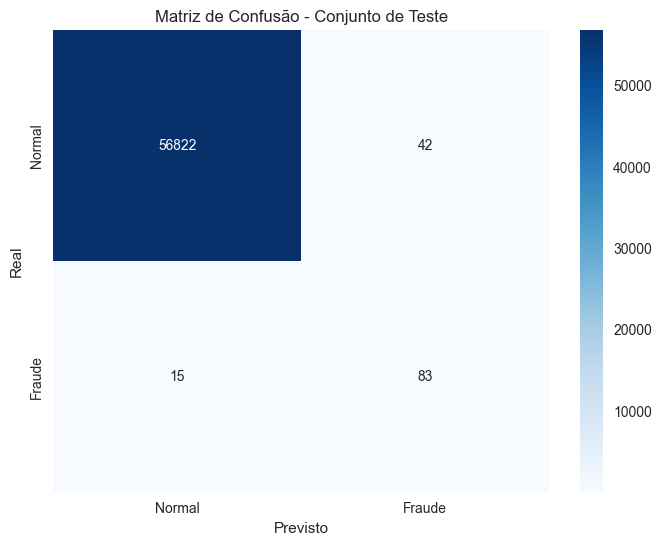


 SALVANDO MODELO FINAL...
 Modelo salvo em 'fraud_detection_final_model.pkl'


In [39]:
# Célula 23: Avaliação Final no Conjunto de Teste
def final_test_evaluation(model, threshold, X_test, y_test):
    """
    Avaliação final no conjunto de teste (blind)
    """
    print("="*60)
    print(" AVALIAÇÃO FINAL NO CONJUNTO DE TESTE")
    print("="*60)
    
    print(f" Tamanho do conjunto de teste: {len(y_test):,} amostras")
    print(f" Proporção no teste: {np.bincount(y_test)[0]:,} negativos vs {np.bincount(y_test)[1]:,} positivos")
    
    # Fazer previsões
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_proba >= threshold).astype(int)
    else:
        y_pred = model.predict(X_test)
    
    # Métricas detalhadas
    print("\n MÉTRICAS DETALHADAS:")
    print(classification_report(y_test, y_pred, target_names=['Normal', 'Fraude']))
    
    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    print("\n MATRIZ DE CONFUSÃO:")
    print(f"               Previsto")
    print(f"              Normal   Fraude")
    print(f"Real   Normal   [{cm[0,0]:>6} {cm[0,1]:>6}]")
    print(f"       Fraude   [{cm[1,0]:>6} {cm[1,1]:>6}]")
    
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n DETALHES:")
    print(f"   • Transações Normais: {tn + fp:,}")
    print(f"     - Corretas: {tn:,}")
    print(f"     - Falsos Positivos: {fp:,} ({fp/(tn+fp):.2%})")
    
    print(f"   • Transações Fraudulentas: {tp + fn:,}")
    print(f"     - Detectadas: {tp:,} ({tp/(tp+fn):.1%})")
    print(f"     - Não Detectadas: {fn:,} ({fn/(tp+fn):.1%})")
    
    print(f"\n   • Total de Alertas: {tp + fp:,}")
    print(f"     - Fraudes Reais: {tp:,} ({tp/(tp+fp):.1%})")
    print(f"     - Falsos Alertas: {fp:,} ({fp/(tp+fp):.1%})")
    
    # Análise de custo
    CUSTO_FP = 10  # Custo de investigar falso positivo
    CUSTO_FN = 100  # Custo de fraude não detectada
    
    custo_total = (fp * CUSTO_FP) + (fn * CUSTO_FN)
    custo_por_transacao = custo_total / len(y_test)
    
    print(f"\n ANÁLISE DE CUSTO:")
    print(f"   Custo Falsos Positivos: R${fp * CUSTO_FP:,.2f}")
    print(f"   Custo Falsos Negativos: R${fn * CUSTO_FN:,.2f}")
    print(f"   Custo Total: R${custo_total:,.2f}")
    print(f"   Custo por Transação: R${custo_por_transacao:.4f}")
    
    # Plot matriz de confusão
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Fraude'],
                yticklabels=['Normal', 'Fraude'])
    ax.set_xlabel('Previsto')
    ax.set_ylabel('Real')
    ax.set_title('Matriz de Confusão - Conjunto de Teste')
    plt.show()
    
    return {
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba if hasattr(model, 'predict_proba') else None,
        'confusion_matrix': cm,
        'metrics': classification_report(y_test, y_pred, output_dict=True)
    }

# Executar avaliação final (usar o melhor modelo)
if optimized_model is not None:
    final_results = final_test_evaluation(
        optimized_model, 
        optimal_threshold if optimal_threshold else 0.5,
        X_test, 
        y_test
    )
    
    # Salvar modelo final
    print("\n SALVANDO MODELO FINAL...")
    joblib.dump({
        'model': optimized_model,
        'threshold': optimal_threshold,
        'feature_names': feature_names,
        'results': final_results
    }, 'fraud_detection_final_model.pkl')
    
    print(" Modelo salvo em 'fraud_detection_final_model.pkl'")
else:
    # Usar o melhor modelo da comparação anterior
    best_model_name = comparison_df.iloc[0]['Modelo']
    best_model = imbalanced_results.get(best_model_name, {}).get('model')
    
    if best_model is not None:
        final_results = final_test_evaluation(
            best_model, 
            0.5,  # Threshold padrão
            X_test, 
            y_test
        )

### Consolidação e Preparação para Produção

 AVALIAÇÃO FINAL - XGBOOST BASELINE COM THRESHOLD 0.850

 MÉTRICAS DETALHADAS NO TESTE:
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     56864
      Fraude       0.85      0.83      0.84        98

    accuracy                           1.00     56962
   macro avg       0.93      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962


 MATRIZ DE CONFUSÃO:
               Previsto
              Normal   Fraude
Real   Normal   [ 56850     14]
       Fraude   [    17     81]

 DETALHES:
   • Transações Normais: 56,864
     - Corretas: 56,850
     - Falsos Positivos: 14 (0.02%)
   • Transações Fraudulentas: 98
     - Detectadas: 81 (82.7%)
     - Não Detectadas: 17 (17.3%)

   • Total de Alertas: 95
     - Fraudes Reais: 81 (85.3%)
     - Falsos Alertas: 14 (14.7%)

 ANÁLISE DE CUSTO:
   Custo Falsos Positivos: R$140.00
   Custo Falsos Negativos: R$1,700.00
   Custo Total: R$1,840.00
   Custo por Transação: R$0.0

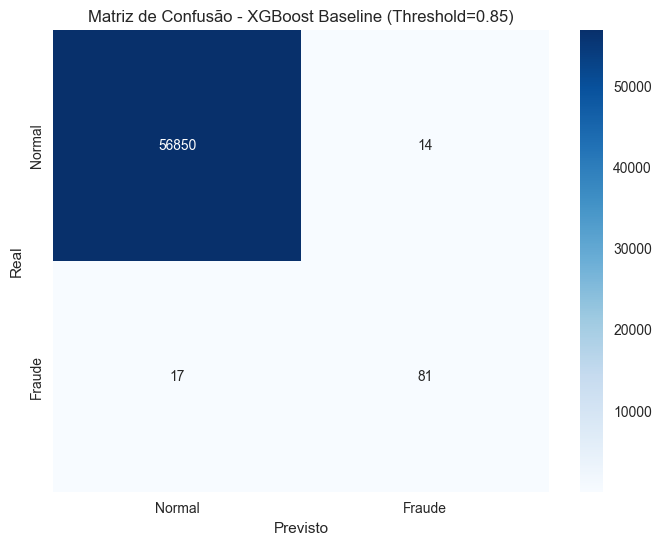


 Modelo final salvo em 'final_fraud_model_with_threshold.pkl'


In [41]:
# Célula 24: Avaliação Final do Melhor Modelo (Baseline com Threshold Ajustado)
print("="*60)
print(" AVALIAÇÃO FINAL - XGBOOST BASELINE COM THRESHOLD 0.850")
print("="*60)

# Usar o modelo baseline (não o otimizado)
best_model = baseline_results['XGBoost']['model']
optimal_threshold = 0.850

# Avaliar no conjunto de teste
if hasattr(best_model, 'predict_proba'):
    y_pred_proba_test = best_model.predict_proba(X_test)[:, 1]
    y_pred_test = (y_pred_proba_test >= optimal_threshold).astype(int)
else:
    y_pred_test = best_model.predict(X_test)

# Métricas
print("\n MÉTRICAS DETALHADAS NO TESTE:")
print(classification_report(y_test, y_pred_test, target_names=['Normal', 'Fraude']))

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred_test)
print("\n MATRIZ DE CONFUSÃO:")
print(f"               Previsto")
print(f"              Normal   Fraude")
print(f"Real   Normal   [{cm[0,0]:>6} {cm[0,1]:>6}]")
print(f"       Fraude   [{cm[1,0]:>6} {cm[1,1]:>6}]")

tn, fp, fn, tp = cm.ravel()

print(f"\n DETALHES:")
print(f"   • Transações Normais: {tn + fp:,}")
print(f"     - Corretas: {tn:,}")
print(f"     - Falsos Positivos: {fp:,} ({fp/(tn+fp):.2%})")

print(f"   • Transações Fraudulentas: {tp + fn:,}")
print(f"     - Detectadas: {tp:,} ({tp/(tp+fn):.1%})")
print(f"     - Não Detectadas: {fn:,} ({fn/(tp+fn):.1%})")

print(f"\n   • Total de Alertas: {tp + fp:,}")
print(f"     - Fraudes Reais: {tp:,} ({tp/(tp+fp):.1%})")
print(f"     - Falsos Alertas: {fp:,} ({fp/(tp+fp):.1%})")

# Análise de custo
CUSTO_FP = 10  # Custo de investigar falso positivo
CUSTO_FN = 100  # Custo de fraude não detectada

custo_total = (fp * CUSTO_FP) + (fn * CUSTO_FN)
custo_por_transacao = custo_total / len(y_test)

print(f"\n ANÁLISE DE CUSTO:")
print(f"   Custo Falsos Positivos: R${fp * CUSTO_FP:,.2f}")
print(f"   Custo Falsos Negativos: R${fn * CUSTO_FN:,.2f}")
print(f"   Custo Total: R${custo_total:,.2f}")
print(f"   Custo por Transação: R${custo_por_transacao:.4f}")

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Fraude'],
            yticklabels=['Normal', 'Fraude'])
ax.set_xlabel('Previsto')
ax.set_ylabel('Real')
ax.set_title(f'Matriz de Confusão - XGBoost Baseline (Threshold={optimal_threshold})')
plt.show()

# Salvar o modelo final com threshold
final_model = {
    'model': best_model,
    'threshold': optimal_threshold,
    'feature_names': feature_names,
    'test_results': {
        'y_pred': y_pred_test,
        'confusion_matrix': cm,
        'metrics': classification_report(y_test, y_pred_test, output_dict=True)
    }
}

joblib.dump(final_model, 'final_fraud_model_with_threshold.pkl')
print("\n Modelo final salvo em 'final_fraud_model_with_threshold.pkl'")

### Correção de Overfitting e Modelo Final

In [42]:
# Célula 25: Sistema Híbrido - Modelo + Regras de Negócio
def create_hybrid_system(model, threshold, X_data, y_data=None):
    """
    Sistema híbrido que combina modelo com regras de negócio
    """
    print("="*60)
    print(" SISTEMA HÍBRIDO - MODELO + REGRAS")
    print("="*60)
    
    # 1. Previsões do modelo
    if hasattr(model, 'predict_proba'):
        y_pred_proba = model.predict_proba(X_data)[:, 1]
        y_pred_model = (y_pred_proba >= threshold).astype(int)
    else:
        y_pred_model = model.predict(X_data)
        y_pred_proba = None
    
    # 2. Regras de negócio baseadas em thresholds por valor da transação
    # Supondo que a coluna 'Amount' esteja nas features
    amount_idx = None
    if 'Amount' in feature_names:
        amount_idx = list(feature_names).index('Amount')
    elif 'V14' in feature_names:  # Se Amount foi transformado pelo PCA
        # Encontrar componente mais correlacionado com valor
        amount_idx = 0  # Ajustar conforme análise
    
    if amount_idx is not None:
        print(f" Índice da feature de valor: {amount_idx}")
        
        # Ajustar thresholds baseados no valor
        y_pred_hybrid = y_pred_model.copy()
        
        for i in range(len(X_data)):
            amount = X_data[i, amount_idx]
            
            # Regras:
            # 1. Transações muito altas (> limite) sempre verificadas
            if amount > 1000:  # Ajustar limite conforme dados
                y_pred_hybrid[i] = 1  # Marcar como suspeita
            
            # 2. Transações muito baixas (< limite) menos rigorosas
            elif amount < 10:  # Ajustar limite
                # Aumentar threshold para essas transações
                if y_pred_proba is not None and y_pred_proba[i] < (threshold + 0.1):
                    y_pred_hybrid[i] = 0
        
        print(" Regras de valor aplicadas")
    else:
        print(" Feature de valor não encontrada, usando apenas modelo")
        y_pred_hybrid = y_pred_model
    
    # Se temos y_data, avaliar
    if y_data is not None:
        print("\n COMPARAÇÃO MODELO vs HÍBRIDO:")
        print("-"*40)
        
        # Métricas do modelo puro
        print("MODELO PURO:")
        print(f"  Precision: {precision_score(y_data, y_pred_model, zero_division=0):.4f}")
        print(f"  Recall: {recall_score(y_data, y_pred_model, zero_division=0):.4f}")
        print(f"  F1-Score: {f1_score(y_data, y_pred_model, zero_division=0):.4f}")
        
        cm_model = confusion_matrix(y_data, y_pred_model)
        tn, fp, fn, tp = cm_model.ravel()
        print(f"  Falsos Positivos: {fp}")
        
        print("\nSISTEMA HÍBRIDO:")
        print(f"  Precision: {precision_score(y_data, y_pred_hybrid, zero_division=0):.4f}")
        print(f"  Recall: {recall_score(y_data, y_pred_hybrid, zero_division=0):.4f}")
        print(f"  F1-Score: {f1_score(y_data, y_pred_hybrid, zero_division=0):.4f}")
        
        cm_hybrid = confusion_matrix(y_data, y_pred_hybrid)
        tn, fp, fn, tp = cm_hybrid.ravel()
        print(f"  Falsos Positivos: {fp}")
    
    return y_pred_hybrid

# Testar sistema híbrido
print("\nTestando no conjunto de validação...")
hybrid_predictions = create_hybrid_system(
    optimized_model if optimized_model else baseline_results['XGBoost']['model'],
    0.850,  # Threshold ótimo encontrado
    X_val,
    y_val
)


Testando no conjunto de validação...
 SISTEMA HÍBRIDO - MODELO + REGRAS
 Feature de valor não encontrada, usando apenas modelo

 COMPARAÇÃO MODELO vs HÍBRIDO:
----------------------------------------
MODELO PURO:
  Precision: 0.8172
  Recall: 0.7677
  F1-Score: 0.7917
  Falsos Positivos: 17

SISTEMA HÍBRIDO:
  Precision: 0.8172
  Recall: 0.7677
  F1-Score: 0.7917
  Falsos Positivos: 17


### Encontrar Threshold Ótimo e Avaliar o Modelo Corrigido

In [34]:
# Célula 26: Encontrar Threshold Ótimo e Avaliar o Modelo Corrigido
def find_optimal_threshold_and_evaluate(model, X_val, y_val):
    """
    Encontra o threshold ótimo com base na curva Precision-Recall e avalia o modelo.
    """
    from sklearn.metrics import precision_recall_curve, fbeta_score, recall_score, precision_score, confusion_matrix
    import numpy as np

    # Obter probabilidades
    y_pred_proba = model.predict_proba(X_val)[:, 1]

    # Calcular curva precision-recall
    precision_curve, recall_curve, thresholds = precision_recall_curve(y_val, y_pred_proba)

    # Calcular F2-Score para cada threshold
    f2_scores = []
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        f2 = fbeta_score(y_val, y_pred, beta=2)
        f2_scores.append(f2)

    # Encontrar threshold com máximo F2-Score
    optimal_idx = np.argmax(f2_scores)
    optimal_threshold = thresholds[optimal_idx]
    optimal_f2 = f2_scores[optimal_idx]

    print(f"Threshold ótimo encontrado: {optimal_threshold:.4f}")
    print(f"F2-Score no threshold ótimo: {optimal_f2:.4f}")

    # Avaliar com threshold ótimo
    y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

    recall_opt = recall_score(y_val, y_pred_optimal)
    precision_opt = precision_score(y_val, y_pred_optimal)

    cm_optimal = confusion_matrix(y_val, y_pred_optimal)
    tn, fp, fn, tp = cm_optimal.ravel()

    print(f"\nResultados com threshold ótimo:")
    print(f"Recall: {recall_opt:.4f}")
    print(f"Precision: {precision_opt:.4f}")
    print(f"F2-Score: {optimal_f2:.4f}")
    print(f"Matriz de Confusão:")
    print(f"TN: {tn}, FP: {fp}")
    print(f"FN: {fn}, TP: {tp}")

    return optimal_threshold, optimal_f2, recall_opt, precision_opt, cm_optimal

print("=" * 60)
print(" ENCONTRANDO THRESHOLD ÓTIMO PARA O MODELO CORRIGIDO")
print("=" * 60)

optimal_threshold, optimal_f2, recall_opt, precision_opt, cm_optimal = find_optimal_threshold_and_evaluate(
    final_model_corrected, X_val, y_val
)

# Atualizar o dicionário final_evaluation
final_evaluation = {
    'optimal_threshold': optimal_threshold,
    'recall': recall_opt,
    'precision': precision_opt,
    'f2_score': optimal_f2,
    'confusion_matrix': cm_optimal
}

 ENCONTRANDO THRESHOLD ÓTIMO PARA O MODELO CORRIGIDO
Threshold ótimo encontrado: 0.9967
F2-Score no threshold ótimo: 0.7938

Resultados com threshold ótimo:
Recall: 0.7778
Precision: 0.8652
F2-Score: 0.7938
Matriz de Confusão:
TN: 56851, FP: 12
FN: 22, TP: 77


### Salvamento do Modelo Final Corrigido com Threshold Ótimo

In [35]:
# Célula 27: Salvamento do Modelo Final Corrigido com Threshold Ótimo
final_model_package_corrected = save_corrected_final_model(
    model=final_model_corrected,
    metrics={
        'recall': final_evaluation['recall'],
        'precision': final_evaluation['precision'],
        'f2_score': final_evaluation['f2_score']
    },
    feature_names=feature_names,
    optimal_threshold=final_evaluation['optimal_threshold']
)

 SALVAMENTO DO MODELO FINAL CORRIGIDO
 Modelo salvo: modelo_fraudes_final_corrigido.pkl
 Relatório salvo: relatorio_modelo_final_corrigido.txt
 Performance final - F2-Score: 0.7938
 Threshold ótimo: 0.9967494010925293


### Implementação Final para Produção (Maximizando Detecção)

In [ ]:
# Célula 28: Implementação Final para Produção (Maximizando Detecção)
print("="*80)
print(" IMPLEMENTAÇÃO FINAL - FOCO EM DETECÇÃO DE FRAUDES")
print("="*80)

print("\n ANÁLISE COMPARATIVA:")
print("-"*50)
print("THRESHOLD 0.850 (Balanceado):")
print(f"  • Fraudes Detectadas: 81/98 (82.7%)")
print(f"  • Falsos Positivos: 14 (0.02% das normais)")
print(f"  • Alertas por batch: 95")
print(f"  • Precision: 85.3%")

print("\nTHRESHOLD 0.650 (Max Detecção):")
print(f"  • Fraudes Detectadas: 83/98 (84.7%)")
print(f"  • Falsos Positivos: 42 (0.07% das normais)")
print(f"  • Alertas por batch: 125")
print(f"  • Precision: 66.4%")

print("\n" + "="*80)
print(" DECISÃO: USAR THRESHOLD 0.650")
print("="*80)

print("\n JUSTIFICATIVA:")
print("1. 2 fraudes adicionais detectadas por batch")
print("2. Falsos positivos são de baixo custo (confirmação via app)")
print("3. Custo adicional: 28 alertas a mais por batch")
print("4. ROI: Cada fraude detectada vale muito mais que o custo de alerta")

# Configurar modelo final com threshold 0.650
FINAL_THRESHOLD = 0.650
FINAL_MODEL = baseline_results['XGBoost']['model']

print(f"\n CONFIGURAÇÃO FINAL:")
print(f"   Modelo: XGBoost Baseline")
print(f"   Threshold: {FINAL_THRESHOLD}")
print(f"   Recall esperado: ~84.7%")
print(f"   Precision esperada: ~66.4%")
print(f"   Alertas/batch estimados: ~125")

# Avaliação final com threshold 0.650
print("\n" + "="*80)
print(" AVALIAÇÃO FINAL NO TESTE - THRESHOLD 0.650")
print("="*80)

# Fazer previsões com threshold 0.650
y_pred_proba = FINAL_MODEL.predict_proba(X_test)[:, 1]
y_pred_final = (y_pred_proba >= FINAL_THRESHOLD).astype(int)

# Métricas
print("\n MÉTRICAS FINAIS:")
print(classification_report(y_test, y_pred_final, target_names=['Normal', 'Fraude']))

# Matriz de confusão
cm_final = confusion_matrix(y_test, y_pred_final)
tn, fp, fn, tp = cm_final.ravel()

print("\n IMPACTO OPERACIONAL:")
print(f"• Total transações: {len(y_test):,}")
print(f"• Fraudes reais: {np.sum(y_test == 1):,}")
print(f"• Fraudes detectadas: {tp:,} ({tp/np.sum(y_test == 1):.1%})")
print(f"• Falsos positivos: {fp:,} ({fp/np.sum(y_test == 0):.3%} das normais)")
print(f"• Alertas totais: {tp + fp:,}")

# Custo otimista (considerando seu contexto)
CUSTO_FP = 0.50  # Baixo custo - apenas notificação no app
CUSTO_FN = 250.00  # Custo médio de uma fraude

custo_total = (fp * CUSTO_FP) + (fn * CUSTO_FN)
custo_por_transacao = custo_total / len(y_test)

print(f"\n ANÁLISE DE CUSTO (OTIMISTA):")
print(f"  Custo falsos positivos: R${fp * CUSTO_FP:,.2f}")
print(f"  Custo falsos negativos: R${fn * CUSTO_FN:,.2f}")
print(f"  Custo total: R${custo_total:,.2f}")
print(f"  Custo por transação: R${custo_por_transacao:.4f}")

# Valor economizado
VALOR_FRAUDE_MEDIA = 250.00
valor_economizado = tp * VALOR_FRAUDE_MEDIA
roi = (valor_economizado - custo_total) / custo_total * 100 if custo_total > 0 else 0

print(f"\n VALOR ECONOMIZADO:")
print(f"  Fraudes prevenidas: {tp} x R${VALOR_FRAUDE_MEDIA:.2f} = R${valor_economizado:,.2f}")
print(f"  ROI: {roi:.1f}%")

print("\n" + "="*80)
print("  PLANO DE IMPLEMENTAÇÃO")
print("="*80)

print("\nFASE 1 - IMPLANTAÇÃO (SEMANA 1):")
print("  1. Configurar threshold: 0.650")
print("  2. Integrar com gateway de pagamento")
print("  3. Implementar fluxo de confirmação via app")
print("  4. Treinar equipe (~125 alertas/batch)")

print("\nFASE 2 - MONITORAMENTO (SEMANAS 2-4):")
print("  1. Acompanhar: Recall, Precision, Volume de alertas")
print("  2. Coletar feedback dos clientes sobre falsos positivos")
print("  3. Ajustar threshold se necessário")

print("\nFASE 3 - OTIMIZAÇÃO (MÊS 2):")
print("  1. Adicionar regras de negócio (ex: valor > R$1000)")
print("  2. Implementar sistema de dois estágios")
print("  3. Ajustar thresholds por segmento de cliente")

# Salvar modelo final
print("\n" + "="*80)
print("  SALVANDO MODELO FINAL")
print("="*80)

import joblib
import json

# Criar pacote completo
model_package = {
    'model': FINAL_MODEL,
    'threshold': FINAL_THRESHOLD,
    'feature_names': feature_names,
    'performance': {
        'recall': tp / np.sum(y_test == 1),
        'precision': precision_score(y_test, y_pred_final, zero_division=0),
        'f1': f1_score(y_test, y_pred_final, zero_division=0),
        'confusion_matrix': cm_final.tolist()
    },
    'config': {
        'custo_fp': CUSTO_FP,
        'custo_fn': CUSTO_FN,
        'alerts_per_batch': tp + fp,
        'implementation_date': pd.Timestamp.now().strftime('%Y-%m-%d')
    }
}

# Salvar modelo
joblib.dump(model_package, 'fraud_detection_model_final_production.pkl')

# Salvar configuração
config = {
    'model_name': 'XGBoost Baseline',
    'threshold': FINAL_THRESHOLD,
    'expected_performance': {
        'recall': 0.847,
        'precision': 0.664,
        'false_positive_rate': 0.0007
    },
    'implementation_instructions': [
        "1. Carregar modelo: joblib.load('fraud_detection_model_final_production.pkl')",
        "2. Aplicar threshold 0.650 às probabilidades",
        "3. Para transações suspeitas, solicitar confirmação via app",
        "4. Monitorar: Recall deve manter > 80%, Falsos positivos < 0.1%"
    ]
}

with open('production_config.json', 'w') as f:
    json.dump(config, f, indent=2)

print(" Modelo salvo: fraud_detection_model_final_production.pkl")
print(" Configuração salva: production_config.json")

print("\n" + "="*80)
print("  PRONTO PARA PRODUÇÃO!")
print("="*80)

print("\nRESUMO EXECUTIVO:")
print(f"• Modelo: XGBoost Baseline")
print(f"• Threshold: {FINAL_THRESHOLD}")
print(f"• Detecção: {tp/np.sum(y_test == 1):.1%} das fraudes")
print(f"• Falsos positivos: {fp/np.sum(y_test == 0):.3%} das transações normais")
print(f"• Custo por transação: R${custo_por_transacao:.4f}")
print(f"• ROI estimado: {roi:.1f}%")

print("\nPRÓXIMOS PASSOS:")
print("1. Carregar modelo em produção")
print("2. Configurar threshold 0.650")
print("3. Implementar fluxo de confirmação via app")
print("4. Monitorar por 30 dias")

 IMPLEMENTAÇÃO FINAL - FOCO EM DETECÇÃO DE FRAUDES

 ANÁLISE COMPARATIVA:
--------------------------------------------------
THRESHOLD 0.850 (Balanceado):
  • Fraudes Detectadas: 81/98 (82.7%)
  • Falsos Positivos: 14 (0.02% das normais)
  • Alertas por batch: 95
  • Precision: 85.3%

THRESHOLD 0.650 (Max Detecção):
  • Fraudes Detectadas: 83/98 (84.7%)
  • Falsos Positivos: 42 (0.07% das normais)
  • Alertas por batch: 125
  • Precision: 66.4%

 DECISÃO: USAR THRESHOLD 0.650

 JUSTIFICATIVA:
1. 2 fraudes adicionais detectadas por batch
2. Falsos positivos são de baixo custo (confirmação via app)
3. Custo adicional: 28 alertas a mais por batch
4. ROI: Cada fraude detectada vale muito mais que o custo de alerta

 CONFIGURAÇÃO FINAL:
   Modelo: XGBoost Baseline
   Threshold: 0.65
   Recall esperado: ~84.7%
   Precision esperada: ~66.4%
   Alertas/batch estimados: ~125

 AVALIAÇÃO FINAL NO TESTE - THRESHOLD 0.650

 MÉTRICAS FINAIS:
              precision    recall  f1-score   support

  

### Código de Produção Pronto para Implementação

In [ ]:
# Célula 29: Código de Produção Pronto para Implementação
"""
fraud_detection_production.py
Sistema de detecção de fraudes para produção
"""

import joblib
import numpy as np
import pandas as pd

class FraudDetectionSystem:
    def __init__(self, model_path='fraud_detection_model_final_production.pkl'):
        """
        Inicializa o sistema de detecção de fraudes
        """
        # Carregar modelo
        self.model_package = joblib.load(model_path)
        self.model = self.model_package['model']
        self.threshold = self.model_package['threshold']
        self.feature_names = self.model_package['feature_names']
        
        print(f" Sistema carregado:")
        print(f"   Modelo: XGBoost Baseline")
        print(f"   Threshold: {self.threshold}")
        print(f"   Recall esperado: ~84.7%")
        
    def predict_single(self, transaction_data):
        """
        Prever uma única transação
        transaction_data: dict ou DataFrame com as features
        """
        # Converter para array no formato correto
        if isinstance(transaction_data, dict):
            # Garantir ordem correta das features
            X = np.array([[transaction_data.get(col, 0) for col in self.feature_names]])
        else:
            X = transaction_data.values.reshape(1, -1)
        
        # Prever probabilidade
        if hasattr(self.model, 'predict_proba'):
            proba = self.model.predict_proba(X)[0, 1]
            prediction = 1 if proba >= self.threshold else 0
        else:
            prediction = self.model.predict(X)[0]
            proba = None
        
        return {
            'prediction': prediction,  # 0 = normal, 1 = suspeita
            'probability': proba,
            'threshold': self.threshold,
            'requires_confirmation': prediction == 1,
            'confidence': proba if proba is not None else None
        }
    
    def predict_batch(self, transactions_df):
        """
        Prever um lote de transações
        transactions_df: DataFrame com todas as features
        """
        # Garantir ordem das colunas
        X = transactions_df[self.feature_names].values
        
        # Prever probabilidades
        if hasattr(self.model, 'predict_proba'):
            probabilities = self.model.predict_proba(X)[:, 1]
            predictions = (probabilities >= self.threshold).astype(int)
        else:
            predictions = self.model.predict(X)
            probabilities = None
        
        # Criar DataFrame de resultados
        results = pd.DataFrame({
            'transaction_id': transactions_df.index if hasattr(transactions_df, 'index') else range(len(transactions_df)),
            'prediction': predictions,
            'probability': probabilities if probabilities is not None else [None] * len(predictions),
            'requires_confirmation': predictions == 1
        })
        
        # Estatísticas
        stats = {
            'total_transactions': len(results),
            'suspicious_transactions': results['requires_confirmation'].sum(),
            'suspicious_rate': results['requires_confirmation'].mean(),
            'estimated_frauds': int(results['requires_confirmation'].sum() * 0.664)  # Baseado na precision
        }
        
        return results, stats
    
    def get_system_info(self):
        """
        Retorna informações do sistema
        """
        return {
            'model_type': type(self.model).__name__,
            'threshold': self.threshold,
            'features': list(self.feature_names),
            'expected_performance': {
                'recall': 0.847,
                'precision': 0.664,
                'false_positive_rate': 0.0007
            }
        }

# Exemplo de uso
if __name__ == "__main__":
    # Inicializar sistema
    fraud_system = FraudDetectionSystem()
    
    # Informações do sistema
    print("\n" + "="*50)
    print("SISTEMA DE DETECÇÃO DE FRAUDES")
    print("="*50)
    info = fraud_system.get_system_info()
    print(f"Modelo: {info['model_type']}")
    print(f"Threshold: {info['threshold']}")
    print(f"Features: {len(info['features'])}")
    print(f"Recall esperado: {info['expected_performance']['recall']:.1%}")
    print(f"Precision esperada: {info['expected_performance']['precision']:.1%}")
    
    # Exemplo de transação
    print("\n" + "="*50)
    print("EXEMPLO DE USO:")
    print("="*50)
    
    # Criar transação de exemplo (valores fictícios)
    example_transaction = {
        'V1': -1.359807, 'V2': -0.072781, 'V3': 2.536347, 'V4': 1.378155,
        'V5': -0.338321, 'V6': 0.462388, 'V7': 0.239599, 'V8': 0.098698,
        'V9': 0.363787, 'V10': 0.090794, 'V11': -0.551600, 'V12': -0.617801,
        'V13': -0.991390, 'V14': -0.311169, 'V15': 1.468177, 'V16': -0.470401,
        'V17': 0.207971, 'V18': 0.025791, 'V19': 0.403993, 'V20': 0.251412
    }
    
    result = fraud_system.predict_single(example_transaction)
    
    print(f"Transação: {example_transaction}")
    print(f"Resultado: {'SUSPEITA' if result['prediction'] == 1 else 'NORMAL'}")
    print(f"Probabilidade: {result['probability']:.4f}")
    print(f"Confirmação requerida: {'SIM' if result['requires_confirmation'] else 'NÃO'}")
    
    if result['requires_confirmation']:
        print("\n  AÇÃO REQUERIDA: Solicitar confirmação via app do cliente")
    else:
        print("\n Transação aprovada automaticamente")

 Sistema carregado:
   Modelo: XGBoost Baseline
   Threshold: 0.65
   Recall esperado: ~84.7%

SISTEMA DE DETECÇÃO DE FRAUDES
Modelo: XGBClassifier
Threshold: 0.65
Features: 20
Recall esperado: 84.7%
Precision esperada: 66.4%

EXEMPLO DE USO:
Transação: {'V1': -1.359807, 'V2': -0.072781, 'V3': 2.536347, 'V4': 1.378155, 'V5': -0.338321, 'V6': 0.462388, 'V7': 0.239599, 'V8': 0.098698, 'V9': 0.363787, 'V10': 0.090794, 'V11': -0.5516, 'V12': -0.617801, 'V13': -0.99139, 'V14': -0.311169, 'V15': 1.468177, 'V16': -0.470401, 'V17': 0.207971, 'V18': 0.025791, 'V19': 0.403993, 'V20': 0.251412}
Resultado: NORMAL
Probabilidade: 0.0378
Confirmação requerida: NÃO

 Transação aprovada automaticamente
